# Application 2: CollabMap Data Quality
Assessing the quality of crowdsourced data in CollabMap from their provenance

* **Goal**: To determine if the provenance network analytics method can identify trustworthy data (i.e. buildings, routes, and route sets) contributed by crowd workers in [CollabMap](https://collabmap.org/).
* **Classification labels**: $\mathcal{L} = \left\{ \textit{trusted}, \textit{uncertain} \right\} $.
* **Training data**:
  - Buildings: 5175
  - Routes: 4710
  - Route sets: 4997



## Reading data
The CollabMap dataset is provided in the [`collabmap/depgraphs.csv`](collabmap/depgraphs.csv) file, each row corresponds to a building, route, or route sets created in the application:
* `id`: the identifier of the data entity (i.e. building/route/route set).
* `trust_value`: the beta trust value calculated from the votes for the data entity.
* The remaining columns provide the provenance network metrics calculated from the dependency provenance graph of the entity.

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("collabmap/depgraphs.csv", index_col='id')
df.head()

,trust_value,entities,agents,activities,nodes,edges,diameter,assortativity,acc,acc_e,...,mfd_e_a,mfd_e_ag,mfd_a_e,mfd_a_a,mfd_a_ag,mfd_ag_e,mfd_ag_a,mfd_ag_ag,mfd_der,powerlaw_alpha
id,,,,,,,,,,,,,,,,,,,,,
Route41053.0,0.833333,9,0,6,15,26,3,-0.272207,0.891091,0.809409,...,1,0,2,0,0,0,0,0,2,-1.00000
RouteSet9042.1,0.600000,6,0,3,9,15,2,-0.412974,0.879630,0.847222,...,1,0,1,0,0,0,0,0,1,-1.00000
Building19305.0,0.428571,6,0,4,10,13,2,-0.527046,0.901235,0.822222,...,1,0,1,0,0,0,0,0,1,3.19876
Building1136.0,0.428571,6,0,4,10,13,2,-0.527046,0.901235,0.822222,...,1,0,1,0,0,0,0,0,1,3.19876
Building24156.0,0.833333,9,0,5,14,24,3,-0.363937,0.838034,0.757639,...,2,0,2,2,0,0,0,0,2,-1.00000


In [3]:
df.describe()

,trust_value,entities,agents,activities,nodes,edges,diameter,assortativity,acc,acc_e,...,mfd_e_a,mfd_e_ag,mfd_a_e,mfd_a_a,mfd_a_ag,mfd_ag_e,mfd_ag_a,mfd_ag_ag,mfd_der,powerlaw_alpha
count,14882.000000,14882.000000,14882.0,14882.000000,14882.000000,14882.000000,14882.000000,14882.000000,14882.000000,14882.000000,...,14882.000000,14882.0,14882.000000,14882.000000,14882.0,14882.0,14882.0,14882.0,14882.000000,14882.000000
mean,0.766706,13.384693,0.0,6.793375,20.178067,39.118868,2.771267,-0.363791,0.806123,0.762426,...,1.545424,0.0,1.742575,0.987166,0.0,0.0,0.0,0.0,1.802782,-0.226061
std,0.115301,17.165677,0.0,7.247706,24.147888,59.648535,0.917298,0.238658,0.203627,0.200090,...,1.044079,0.0,1.012615,1.391763,0.0,0.0,0.0,0.0,0.938974,1.590865
min,0.153846,2.000000,0.0,0.000000,2.000000,1.000000,1.000000,-1.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,1.000000,-1.000000
25%,0.750000,5.000000,0.0,2.000000,7.000000,10.000000,2.000000,-0.500000,0.820309,0.757639,...,1.000000,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0,1.000000,-1.000000
50%,0.800000,9.000000,0.0,5.000000,14.000000,24.000000,3.000000,-0.330835,0.849790,0.809409,...,1.000000,0.0,2.000000,0.000000,0.0,0.0,0.0,0.0,2.000000,-1.000000
75%,0.833333,14.000000,0.0,9.000000,22.000000,40.000000,3.000000,-0.251256,0.880083,0.854159,...,2.000000,0.0,2.000000,2.000000,0.0,0.0,0.0,0.0,2.000000,-1.000000
max,0.965517,178.000000,0.0,70.000000,248.000000,706.000000,13.000000,0.494008,1.000000,1.000000,...,13.000000,0.0,12.000000,13.000000,0.0,0.0,0.0,0.0,12.000000,4.674298


## Labelling data
Based on its trust value, we categorise the data entity into two sets: _trusted_ and _uncertain_. Here, the threshold for the trust value, whose range is [0, 1], is chosen to be 0.75.

In [4]:
trust_threshold = 0.75
df['label'] = df.apply(lambda row: 'Trusted' if row.trust_value >= trust_threshold else 'Uncertain', axis=1)
df.head()  # The new label column is the last column below

,trust_value,entities,agents,activities,nodes,edges,diameter,assortativity,acc,acc_e,...,mfd_e_ag,mfd_a_e,mfd_a_a,mfd_a_ag,mfd_ag_e,mfd_ag_a,mfd_ag_ag,mfd_der,powerlaw_alpha,label
id,,,,,,,,,,,,,,,,,,,,,
Route41053.0,0.833333,9,0,6,15,26,3,-0.272207,0.891091,0.809409,...,0,2,0,0,0,0,0,2,-1.00000,Trusted
RouteSet9042.1,0.600000,6,0,3,9,15,2,-0.412974,0.879630,0.847222,...,0,1,0,0,0,0,0,1,-1.00000,Uncertain
Building19305.0,0.428571,6,0,4,10,13,2,-0.527046,0.901235,0.822222,...,0,1,0,0,0,0,0,1,3.19876,Uncertain
Building1136.0,0.428571,6,0,4,10,13,2,-0.527046,0.901235,0.822222,...,0,1,0,0,0,0,0,1,3.19876,Uncertain
Building24156.0,0.833333,9,0,5,14,24,3,-0.363937,0.838034,0.757639,...,0,2,2,0,0,0,0,2,-1.00000,Trusted


Having used the trust valuue to label all the data entities, we remove the `trust_value` column from the data frame.

In [5]:
# We will not use trust value from now on
df.drop('trust_value', axis=1, inplace=True)
df.shape  # the dataframe now have 23 columns (22 metrics + label)

(14882, 23)

## Filtering data
We split the dataset into three: buildings, routes, and route sets.

In [6]:
df_buildings = df.filter(like="Building", axis=0)
df_routes = df.filter(regex="^Route\d", axis=0)
df_routesets = df.filter(like="RouteSet", axis=0)
df_buildings.shape, df_routes.shape, df_routesets.shape  # The number of data points in each dataset

((5175, 23), (4997, 23), (4710, 23))

## Balancing Data
This section explore the balance of each of the three datasets and balance them using the [SMOTE Oversampling Method](https://www.jair.org/media/953/live-953-2037-jair.pdf).

In [7]:
from analytics import balance_smote

### Buildings

In [8]:
df_buildings.label.value_counts()

Trusted      4491
Uncertain     684
Name: label, dtype: int64

Balancing the building dataset:

In [9]:
df_buildings = balance_smote(df_buildings)

Original data shapes: (5175, 22) (5175,)
Balanced data shapes: (8982, 22) (8982,)


### Routes

In [10]:
df_routes.label.value_counts()

Trusted      3908
Uncertain    1089
Name: label, dtype: int64

Balancing the route dataset:

In [11]:
df_routes = balance_smote(df_routes)

Original data shapes: (4997, 22) (4997,)
Balanced data shapes: (7816, 22) (7816,)


### Route Sets

In [12]:
df_routesets.label.value_counts()

Trusted      3019
Uncertain    1691
Name: label, dtype: int64

Balancing the route set dataset:

In [13]:
df_routesets = balance_smote(df_routesets)

Original data shapes: (4710, 22) (4710,)
Balanced data shapes: (6038, 22) (6038,)


## Cross Validation

We now run the cross validation tests on the three balanaced datasets (`df_buildings`, `df_routes`, and `df_routesets`) using all the features (`combined`), only the generic network metrics (`generic`), and only the provenance-specific network metrics (`provenance`). Please refer to [Cross Validation Code.ipynb](Cross%20Validation%20Code.ipynb) for the detailed description of the cross validation code.

In [14]:
from analytics import test_classification

### Building Classification

We test the classification of buildings, collect individual accuracy scores `results` and the importance of every feature in each test in `importances` (both are Pandas Dataframes). These two tables will also be used to collect data from testing the classification of routes and route sets later.

In [15]:
# Cross validation test on building classification
res, imps = test_classification(df_buildings)

# adding the Data Type column
res['Data Type'] = 'Building'
imps['Data Type'] = 'Building'

# storing the results and importance of features
results = res
importances = imps

# showing a few newest rows
results.tail()

Accuracy: 90.03% ±0.0576 <-- combined
Accuracy: 90.06% ±0.0557 <-- generic
Accuracy: 89.90% ±0.0581 <-- provenance


,Accuracy,Metrics,Data Type
2995,0.891982,provenance,Building
2996,0.885301,provenance,Building
2997,0.918708,provenance,Building
2998,0.887528,provenance,Building
2999,0.902004,provenance,Building


### Route Classification

In [16]:
# Cross validation test on route classification
res, imps = test_classification(df_routes)

# adding the Data Type column
res['Data Type'] = 'Route'
imps['Data Type'] = 'Route'

# storing the results and importance of features
results = results.append(res, ignore_index=True)
importances = importances.append(imps, ignore_index=True)

# showing a few newest rows
results.tail()

Accuracy: 96.98% ±0.0368 <-- combined
Accuracy: 96.63% ±0.0404 <-- generic
Accuracy: 95.97% ±0.0433 <-- provenance


,Accuracy,Metrics,Data Type
5995,0.943734,provenance,Route
5996,0.960358,provenance,Route
5997,0.964194,provenance,Route
5998,0.957692,provenance,Route
5999,0.958974,provenance,Route


### Route Set Classification

In [17]:
# Cross validation test on route classification
res, imps = test_classification(df_routesets)

# adding the Data Type column
res['Data Type'] = 'Route Set'
imps['Data Type'] = 'Route Set'

# storing the results and importance of features
results = results.append(res, ignore_index=True)
importances = importances.append(imps, ignore_index=True)

# showing a few newest rows
results.tail()

Accuracy: 95.70% ±0.0493 <-- combined
Accuracy: 95.20% ±0.0526 <-- generic
Accuracy: 95.34% ±0.0500 <-- provenance


,Accuracy,Metrics,Data Type
8995,0.950331,provenance,Route Set
8996,0.947020,provenance,Route Set
8997,0.968543,provenance,Route Set
8998,0.965232,provenance,Route Set
8999,0.950166,provenance,Route Set


### Saving experiments' results (optional)

Optionally, we can save the test results to save time the next time we want to re-explore them:

In [18]:
results.to_pickle("collabmap/results.pkl")
importances.to_pickle("collabmap/importances.pkl")

Next time, we can reload the results as follows:

In [19]:
import pandas as pd
results = pd.read_pickle("collabmap/results.pkl")
importances = pd.read_pickle("collabmap/importances.pkl")
results.shape, importances.shape  # showing the shape of the data (for checking)

((9000, 3), (3000, 23))

### Charting the accuracy scores

In [20]:
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.4)

Converting the accuracy score from [0, 1] to percentage, i.e [0, 100]:

In [21]:
results.Accuracy = results.Accuracy * 100
results.head()

,Accuracy,Metrics,Data Type
0,90.444444,combined,Building
1,89.866370,combined,Building
2,90.311804,combined,Building
3,90.200445,combined,Building
4,88.307350,combined,Building


In [22]:
from matplotlib.font_manager import FontProperties
fontP = FontProperties()
fontP.set_size(12)

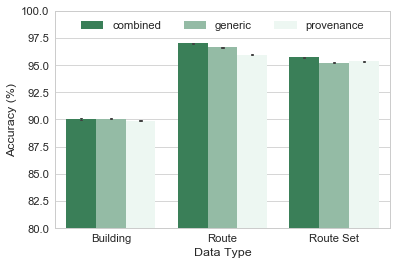

In [23]:
pal = sns.light_palette("seagreen", n_colors=3, reverse=True)
plot = sns.barplot(x="Data Type", y="Accuracy", hue='Metrics', palette=pal, errwidth=1, capsize=0.02, data=results)
plot.set_ylim(80, 100)
plot.legend(loc='upper center', bbox_to_anchor=(0.5, 1.0), ncol=3)
plot.set_ylabel('Accuracy (%)')

Saving the chart above to `Fig4.eps` to be included in the paper:

In [24]:
plot.figure.savefig("figures/Fig4.eps")

### Charting the importance of features

In this section, we explore the relevance of each features in classifying the data quality of CollabMap buildings, routes, and route sets. To do so, we analyse the feature importance values provided by the decision tree training done above - the `importances` data frame.

In [25]:
import numpy as np

In [26]:
# Rename the columns with Math notation for consistency with the metrics symbols in the paper
feature_name_maths_mapping = {
    "entities": "$n_e$", "agents": "$n_{ag}$", "activities": "$n_a$", "nodes": "$n$", "edges": "$e$",
    "diameter": "$d$", "assortativity": "$r$", "acc": "$\\mathsf{ACC}$",
    "acc_e": "$\\mathsf{ACC}_e$",  "acc_a": "$\\mathsf{ACC}_a$",  "acc_ag": "$\\mathsf{ACC}_{ag}$",
    "mfd_e_e": "$\\mathrm{mfd}_{e \\rightarrow e}$", "mfd_e_a": "$\\mathrm{mfd}_{e \\rightarrow a}$",
    "mfd_e_ag": "$\\mathrm{mfd}_{e \\rightarrow ag}$", "mfd_a_e": "$\\mathrm{mfd}_{a \\rightarrow e}$",
    "mfd_a_a": "$\\mathrm{mfd}_{a \\rightarrow a}$", "mfd_a_ag": "$\\mathrm{mfd}_{a \\rightarrow ag}$",
    "mfd_ag_e": "$\\mathrm{mfd}_{ag \\rightarrow e}$", "mfd_ag_a": "$\\mathrm{mfd}_{ag \\rightarrow a}$",
    "mfd_ag_ag": "$\\mathrm{mfd}_{ag \\rightarrow ag}$", "mfd_der": "$\\mathrm{mfd}_\\mathit{der}$", "powerlaw_alpha": "$\\alpha$"
}
importances.rename(columns=feature_name_maths_mapping, inplace=True)

In [27]:
grouped =importances.groupby("Data Type")  # Grouping the importance values by data type

Building          Axes(0.1,0.15;0.235294x0.75)
Route        Axes(0.382353,0.15;0.235294x0.75)
Route Set    Axes(0.664706,0.15;0.235294x0.75)
dtype: object

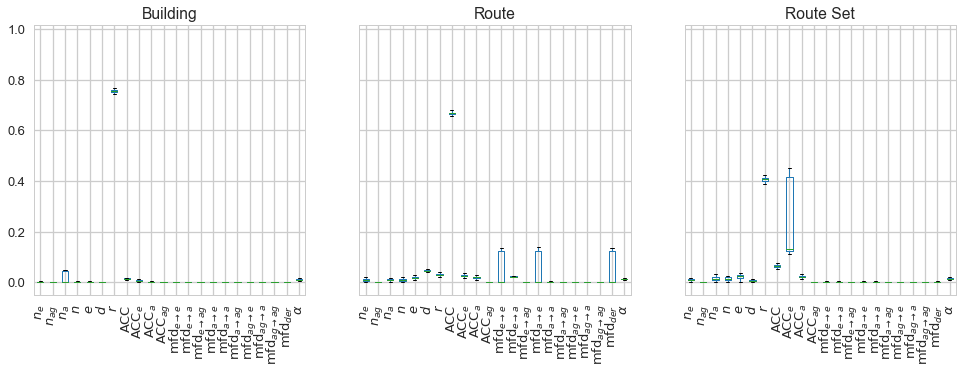

In [28]:
sns.set_context("talk")
grouped.boxplot(figsize=(16, 5), layout=(1, 3), rot=90)

The charts above show us the relevance of each feature in classifying the quality of CollabMap buildings, routes, and route sets. Next, we find the three most relevant features for each data type to report in the paper.

In [29]:
# Calculate the mean importance of each feature for each data type
imp_means = grouped.mean()

In [30]:
pd.DataFrame(
    {row_name: row.sort_values(ascending=False)[:3].index.get_values()
        for row_name, row in imp_means.iterrows()
    }
)

,Building,Route,Route Set
0,$r$,$\mathsf{ACC}$,$r$
1,$\mathsf{ACC}$,$d$,$\mathsf{ACC}_e$
2,$n_a$,$\mathrm{mfd}_\mathit{der}$,$e$


The table above shows the most important metrics as reported by the decision tree classifiers during their training for each dataset.

### Retest the classifications using minimal sets of features (Extra)

Armed with the knowledge of the three most important features in each experiment, we re-run the experiments using only those.

In [31]:
from analytics import cv_test

In [32]:
res, imps = cv_test(df_buildings[['assortativity', 'acc', 'activities']], df_buildings.label, test_id="Building")

Accuracy: 89.96% ±0.0570 <-- Building


In [33]:
res, imps = cv_test(df_routes[['acc', 'diameter', 'mfd_der']], df_routes.label, test_id="Route")

Accuracy: 95.09% ±0.0455 <-- Route


In [34]:
res, imps = cv_test(df_routesets[['assortativity', 'acc_e', 'entities']], df_routesets.label, test_id="Routeset")

Accuracy: 95.05% ±0.0541 <-- Routeset


As shown above, using only _three metrics_ from each dataset, we can still achieve a high level of accuracy from the classifiers: 90%, 95%, and 95% for buildings, routes, and route sets, respectively. The performance is very close to that when all the metrics were used (90%, 97%, 96%, respectively). This shows that, in certain applications, we can select a smaller set of metrics for classification based on the relevancy analysis above to reduce the computational cost without significantly affecting the classification performance.